# **Land Value Prediction Model**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2023.09.10. ~
- Description: Land value prediction model with XGBoost.
------

## **Overview**
이 프로젝트는 회귀 예측 모델인 XGBoost를 사용하여 토지의 실거래가를 예측하는 모델을 만들고, 


### Key Steps:
**1. Load libraries & get data:**

**2. Data Analysis:**
- 학습에 사용될 데이터셋에 대해 데이터 분석을 진행합니다.
- 연속형 변수와 범주형 변수로 나누어 분석을 진행하였습니다.

**3. Data Preprocessing:**
- Handling missing values, encoding categorical variables, and scaling numerical features.

**4. Model Training with XGBoost:**
- Utilizing the XGBoost algorithm for training the predictive model.

**5. Evaluation and Validation:**
- Assessing model performance using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

**6. Hyperparameter Tuning:**
- Fine-tuning model parameters for optimization.

## **1. Load libraries & get data**
### **1-1. Load libraries**
시각화를 위한 matplotlib, seaborn, 데이터 분석을 위한 scipy, 모델 학습을 위한 xgboost 등 필요한 모듈을 임포트 합니다.

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from config import BASE_DIR

# progress bar
import tqdm
from tqdm import trange, notebook

# linear algebra
import numpy as np 

# data processing
import pandas as pd
pd.options.display.float_format = "{: .2f}".format

# data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set(style="white", context="notebook", palette="deep")

# preprocessing
from sklearn.model_selection import train_test_split

# data analysis
from scipy.stats import kstest
from scipy.stats import skew, norm

# model
import xgboost as xgb

# model visualization
from xgboost import plot_importance
from pdpbox import info_plots

# model validation
from sklearn.metrics import mean_squared_error


### **1-2. Load datasets**

학습에 사용할 데이터셋을 불러옵니다.

데이터셋의 구성은 다음과 같습니다.

|항목명|설명|예시|
|:------|:---|:---|
|PNU|토지의 고유 코드|2914012000112310005|
|Year|거래 년도|2016|
|Month|거래 월|6|
|Price|거래 가격|4544628|
|DealArea|거래 면적|1650.3|
|PblntfPclnd|공시지가|2381000|
|RegstrSe|필지|Re1|
|Lndcgr|지목|Lc08|
|LndpclAr|면적|1650.3|
|PrposArea1|용도지역1|A121|
|PrposArea2|용도지역2|A200|
|LadUseSittn|이용상황|Us230|
|TpgrphHg|지세|Hg02|
|TpgrphFrm|형상|Fm01|
|RoadSide|도로접면|Rs02|
|PclndIndex|지가지수|78.027|
|PclndChgRt|지가변동률|0.42|
|AcmtlPclndChgRt|누계지가변동률|1.698|
|LargeClPclndIndex|권역별 지가지수|77.984|
|LargeClPclndChgRt|권역별 지가변동률|0.233|
|LargeClAcmtlPclndChgRt|권역별 누계지가변동률|1.237|
|PPI|생산자물가지수|98.09|
|CPI|소비자물가지수|95.611|
|MT1|가장 가까운 대형마트와의 거리|146|
|MT1_500m|500m 이내에 있는 대형마트 수|1|
|MT1_1000m|1000m 이내에 있는 대형마트 수|2|
|MT1_3000m|3000m 이내에 있는 대형마트 수|7|
|CS2|가장 가까운 편의점과의 거리|
|CS2_500m|500m 이내에 있는 편의점 수|
|CS2_1000m|1000m 이내에 있는 편의점 수|
|CS2_3000m|3000m 이내에 있는 편의점 수|
|PS3|가장 가까운 어린이집 및 유치원과의 거리|
|PS3_500m|500m 이내에 있는 어린이집 및 유치원 수|
|PS3_1000m|1000m 이내에 있는 어린이집 및 유치원 수|
|PS3_3000m|3000m 이내에 있는 어린이집 및 유치원 수|
|SC4|가장 가까운 학교와의 거리|
|SC4_500m|500m 이내에 있는 학교 수|
|SC4_1000m|1000m 이내에 있는 학교 수|
|SC4_3000m|3000m 이내에 있는 학교 수|
|AC5|가장 가까운 학원과의 거리|
|AC5_500m|500m 이내에 있는 학원 수|
|AC5_1000m|1000m 이내에 있는 학원 수|
|AC5_3000m|3000m 이내에 있는 학원 수|
|PK6|가장 가까운 주차장과의 거리|
|PK6_500m|500m 이내에 있는 주차장 수|
|PK6_1000m|1000m 이내에 있는 주차장 수|
|PK6_3000m|3000m 이내에 있는 주차장 수|
|OL7|
|OL7_500m|
|OL7_1000m|
|OL7_3000m|
|SW8|
|SW8_500m|
|SW8_1000m|
|SW8_3000m
|BK9
|BK9_500m
|BK9_1000m
|BK9_3000m
|CT1
|CT1_500m
|CT1_1000m
|CT1_3000m
|AG2
|AG2_500m
|AG2_1000m
|AG2_3000m
|PO3
|PO3_500m
|PO3_1000m
|PO3_3000m
|AT4
|AT4_500m
|AT4_1000m
|AT4_3000m
|AD5
|AD5_500m
|AD5_1000m
|AD5_3000m
|FD6
|FD6_500m
|FD6_1000m
|FD6_3000m
|CE7
|CE7_500m
|CE7_1000m
|CE7_3000m
|HP8
|HP8_500m
|HP8_1000m
|HP8_3000m
|PM9
|PM9_500m
|PM9_1000m
|PM9_3000m
|LandUsePlans

In [2]:
# Load Train Dataset
# DATA_PATH = BASE_DIR + "/Data/DatasetWithoutCdData.csv"
DATA_PATH = BASE_DIR + "/Data/Dataset.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
# PNU 코드 자료형을 문자열로 변경
df["PNU"] = df["PNU"].astype("str")

# PNU 코드 중 시/도 추출
df.insert(loc=1,column="Sido",value=df["PNU"].str.slice(0, 2).astype("object"))
df.insert(loc=2,column="LdCode",value=df["PNU"].str.slice(0, 10).astype("object"))

# PNU 코드, 법정동 코드, 거래 면적 feature 제거
df.drop(["PNU", "LdCode", "DealArea"], axis=1, inplace=True)

## **2. Data analysis**
### **2-1. target feature(거래가)에 대한 분석**

우리가 예측하고자 하는 feature인 Price(거래가)에 대한 데이터 분석을 진행합니다. 실제 거래가의 경우 공시지가와 연관이 크기 때문에, 공시지가와 연관지어 데이터 분석을 진행하였습니다.

지역별로 가격 편차가 크기 때문에 로그 스케일링을 하여 시각화 하였습니다.

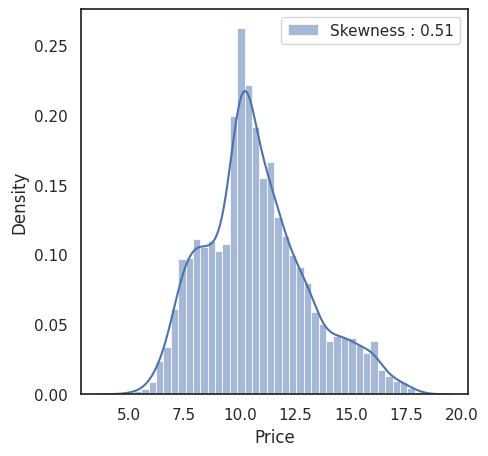

In [4]:
# target frature에 대한 분석
plt.subplots(figsize=(5, 5))
g = sns.histplot(
    np.log1p(df["Price"]),   # 가격 편차가 크기 때문에 log scaling을 해줌
    kde=True,
    stat="density",
    kde_kws=dict(cut=3),
    label = "Skewness : %.2f"%(np.log1p(df["Price"]).skew())
)
g = g.legend(loc="best")

<Axes: ylabel='Price'>

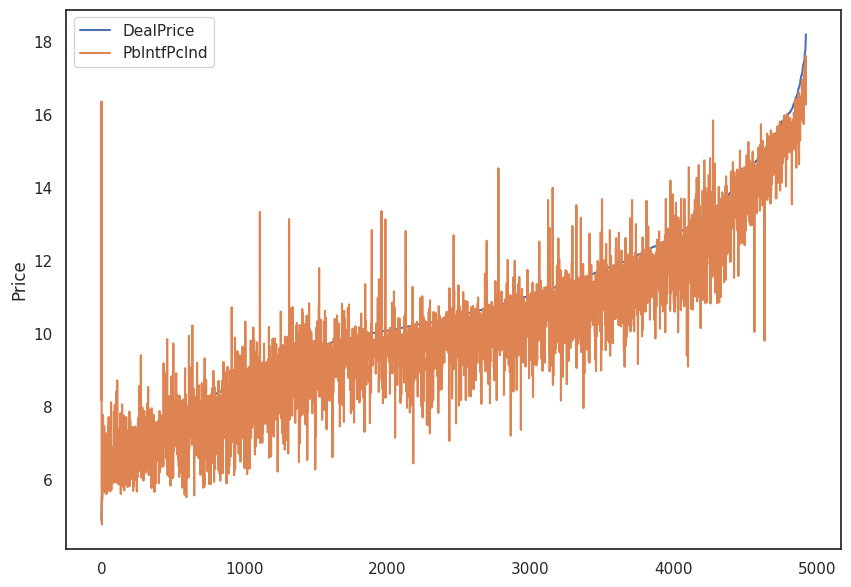

In [5]:
df_price = df[["Price", "PblntfPclnd"]]
df_price = df_price.sort_values("Price").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["Price"]), label="DealPrice")
sns.lineplot(np.log1p(df_price["PblntfPclnd"]), label="PblntfPclnd")

실제 거래가와 공시지가 가격의 격차가 심한 모습을 확인할 수 있습니다. 격차가 매우 심한 데이터의 경우 이상치로 간주할 수 있습니다.

<br/>

### **2-2. 연속형 변수에 대한 데이터 분석**

In [6]:
# 연속형 변수에 대한 데이터 분석
numerical = [var for var in df.columns if df[var].dtype!="O"]  # 연속형 변수 추출
print(numerical)

['Year', 'Month', 'Price', 'PblntfPclnd', 'LndpclAr', 'PclndIndex', 'PclndChgRt', 'AcmtlPclndChgRt', 'LargeClPclndIndex', 'LargeClPclndChgRt', 'LargeClAcmtlPclndChgRt', 'PPI', 'CPI', 'MT1', 'MT1_500m', 'MT1_1000m', 'MT1_3000m', 'CS2', 'CS2_500m', 'CS2_1000m', 'CS2_3000m', 'PS3', 'PS3_500m', 'PS3_1000m', 'PS3_3000m', 'SC4', 'SC4_500m', 'SC4_1000m', 'SC4_3000m', 'AC5', 'AC5_500m', 'AC5_1000m', 'AC5_3000m', 'PK6', 'PK6_500m', 'PK6_1000m', 'PK6_3000m', 'OL7', 'OL7_500m', 'OL7_1000m', 'OL7_3000m', 'SW8', 'SW8_500m', 'SW8_1000m', 'SW8_3000m', 'BK9', 'BK9_500m', 'BK9_1000m', 'BK9_3000m', 'CT1', 'CT1_500m', 'CT1_1000m', 'CT1_3000m', 'AG2', 'AG2_500m', 'AG2_1000m', 'AG2_3000m', 'PO3', 'PO3_500m', 'PO3_1000m', 'PO3_3000m', 'AT4', 'AT4_500m', 'AT4_1000m', 'AT4_3000m', 'AD5', 'AD5_500m', 'AD5_1000m', 'AD5_3000m', 'FD6', 'FD6_500m', 'FD6_1000m', 'FD6_3000m', 'CE7', 'CE7_500m', 'CE7_1000m', 'CE7_3000m', 'HP8', 'HP8_500m', 'HP8_1000m', 'HP8_3000m', 'PM9', 'PM9_500m', 'PM9_1000m', 'PM9_3000m']


연속형 변수에 대한 분석은 상관계수 히트맵을 그려 진행하였습니다.

<Axes: >

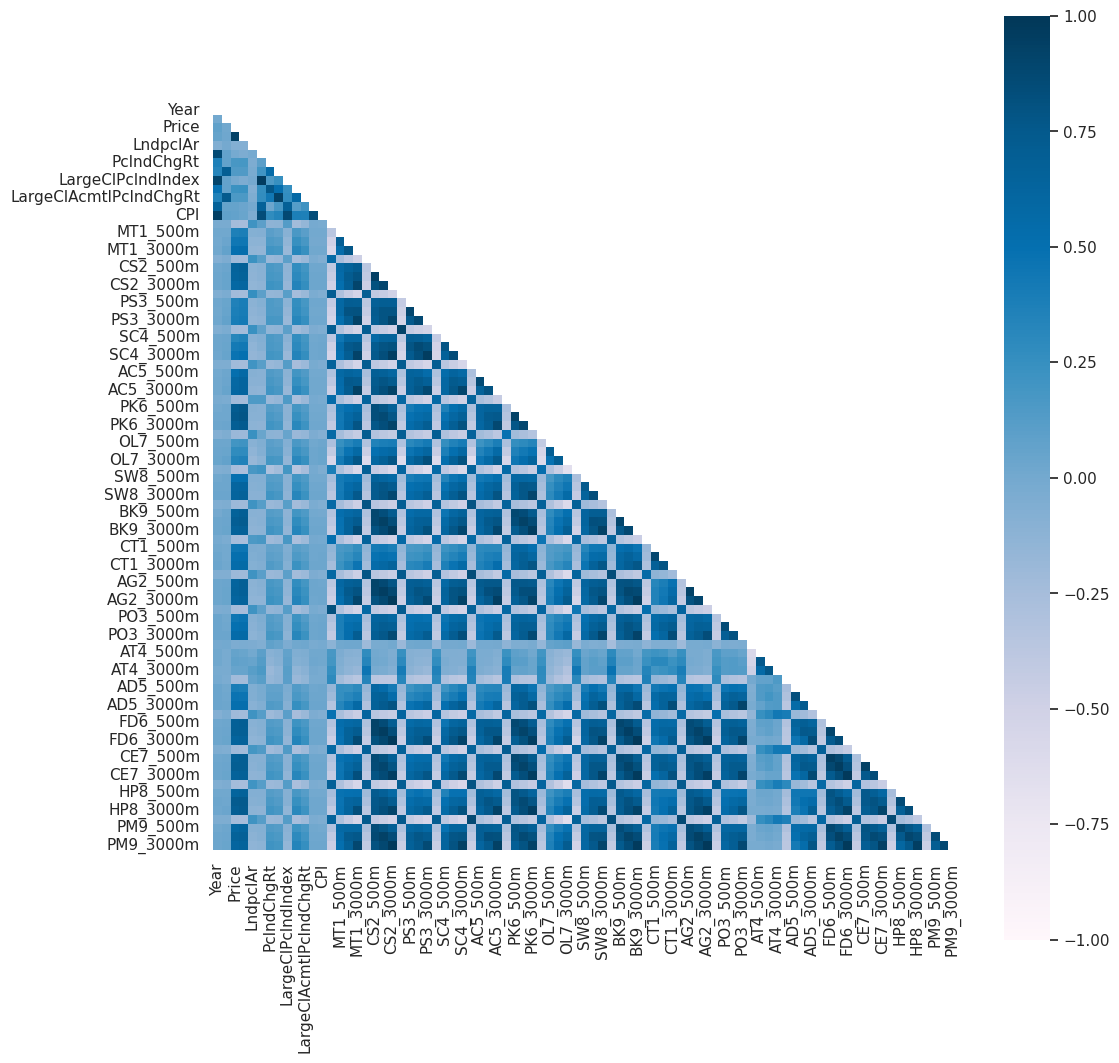

In [7]:
corr = df[numerical].corr(method="pearson")
mask_df = corr
colormap = plt.cm.PuBu

mask = np.zeros_like(mask_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr, 
    vmax=1.0,
    vmin=-1.0,
    square=True, 
    mask=mask,
    cmap=colormap, 
    linecolor="white"
)

공시지가(PblntfPclnd)와의 상관계수가 매우 크게 나타나는 것을 알 수 있고, 이 외에 주변 상권 데이터(몇 미터 이내에 상권이 얼마나 존재하는지)와의 상관계수가 높게 나타난 것을 알 수 있습니다.
수치화해서 보면 다음과 같습니다.

In [8]:
corr["Price"][corr["Price"].values > 0.5].sort_values(ascending=False)

Price          1.00
PblntfPclnd    0.92
PK6_1000m      0.75
HP8_1000m      0.73
PK6_500m       0.72
CE7_1000m      0.70
BK9_1000m      0.70
PK6_3000m      0.70
HP8_3000m      0.70
CE7_500m       0.69
FD6_1000m      0.68
FD6_500m       0.67
BK9_500m       0.66
PM9_1000m      0.66
CE7_3000m      0.65
BK9_3000m      0.65
AG2_1000m      0.65
CS2_500m       0.65
SW8_3000m      0.64
AG2_500m       0.64
CS2_1000m      0.64
HP8_500m       0.64
FD6_3000m      0.63
SW8_1000m      0.62
PM9_3000m      0.62
AG2_3000m      0.62
PM9_500m       0.61
AC5_3000m      0.59
CS2_3000m      0.59
AC5_1000m      0.59
PO3_3000m      0.55
CT1_3000m      0.54
AC5_500m       0.51
AD5_3000m      0.51
CT1_1000m      0.51
MT1_3000m      0.51
SW8_500m       0.50
Name: Price, dtype: float64

### **2-3. 범주형 변수에 대한 분석**

In [9]:
# 범주형 변수에 대한 데이터 분석
categorical = [var for var in df.columns if df[var].dtype=='O']  # 범주형 변수 추출
print(categorical)

['Sido', 'RegstrSe', 'Lndcgr', 'PrposArea1', 'PrposArea2', 'LadUseSittn', 'TpgrphHg', 'TpgrphFrm', 'RoadSide', 'LandUsePlans']


<Axes: xlabel='Sido', ylabel='Price'>

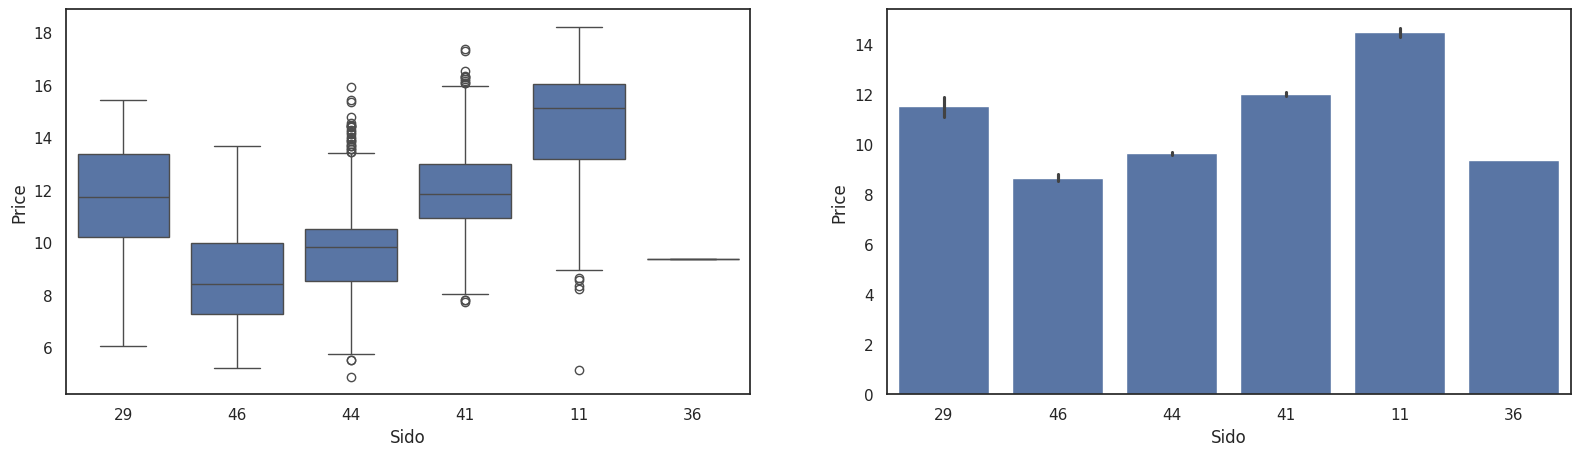

In [10]:
plt.subplots(figsize=(30,5))
plt.clf()
plt.subplot(1, 3, 1)
sns.boxplot(x=df[categorical[0]], y=np.log1p(df["Price"]))
plt.subplot(1, 3, 2)
sns.barplot(x=df[categorical[0]], y=np.log1p(df["Price"]))

위 그래프를 보면 시도별로 가격 차이가 많이 나는 것을 확인할 수 있습니다. 이 외에 다른 데이터에 대한 분석은 `data_analysis.ipynb`에서 확인해 볼 수 있습니다.

## **3. Data preprocessing**
### **3-1. 이상치 제거**
앞서 말했던 대로 공시지가와 가격 차이가 많이 나는 데이터를 이상치로 간주하여 제거하는 작업을 진행해줍니다.

<Axes: xlabel='difference'>

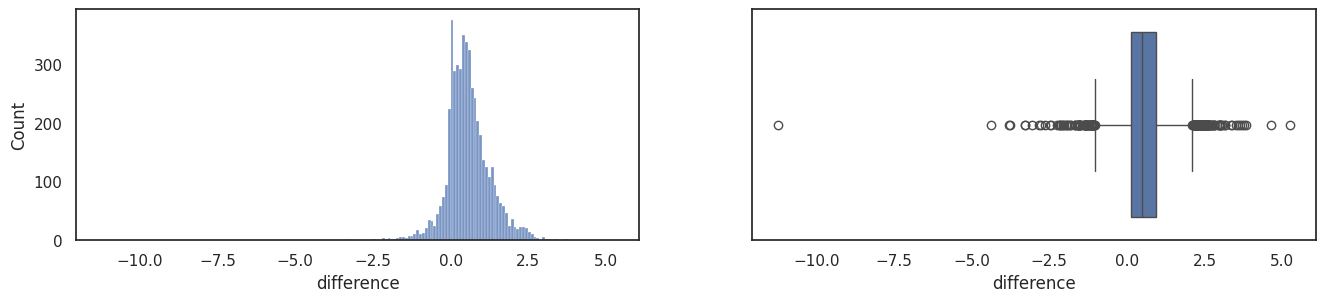

In [11]:
df["difference"] = np.log1p(df["Price"])-np.log1p(df["PblntfPclnd"])

fig, axes = plt.subplots(1, 2, figsize=(16, 3))

sns.histplot(x=df["difference"], ax=axes[0])
sns.boxplot(x=df["difference"], ax=axes[1])

In [12]:
df["difference"].describe()

count    4925.00
mean        0.56
std         0.73
min       -11.24
25%         0.14
50%         0.49
75%         0.92
max         5.25
Name: difference, dtype: float64

1.5*IQR 기법을 통해 이상치 제거를 진행하였습니다.

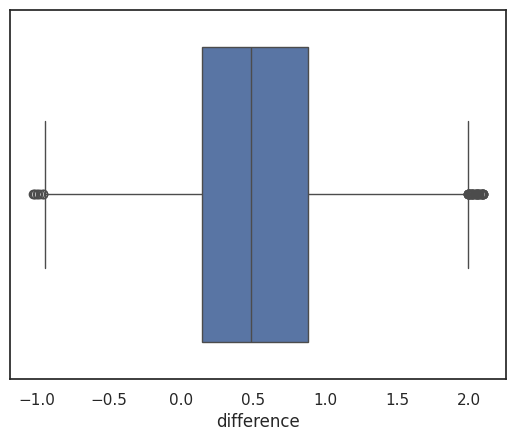

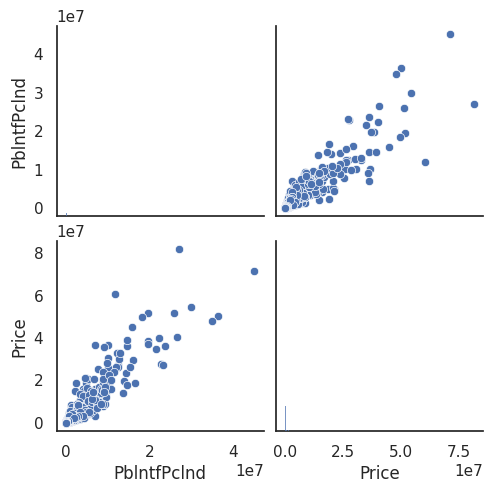

In [13]:
weight = 1.5

quantile_25 = np.percentile(df["difference"].values, 25)
quantile_75 = np.percentile(df["difference"].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df = df[df["difference"].between(lowest, highest)]
sns.boxplot(x=df["difference"])
df = df.drop(["difference"], axis=1)

sns.pairplot(df, vars=["PblntfPclnd", "Price"])
plt.show()

<Axes: ylabel='Price'>

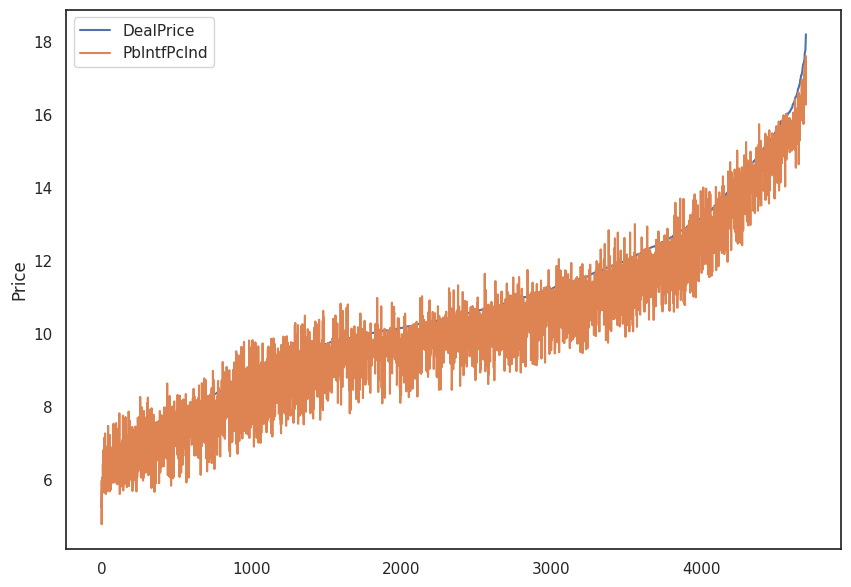

In [14]:
df_price = df[["Price", "PblntfPclnd"]]
df_price = df_price.sort_values("Price").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["Price"]), label="DealPrice")
sns.lineplot(np.log1p(df_price["PblntfPclnd"]), label="PblntfPclnd")

그래프가 안정적으로 바뀐 것을 확인할 수 있습니다.

<br/>

### **3-2. 결측치 제거**
학습 데이터셋에서 값이 누락된 행에 대해 결측치 제거 작업을 진행해 줍니다.

In [15]:
# 결측치 제거
origin_d = df.isnull().sum()  # 결측치 개수 확인
df = df.dropna()
df = df.reset_index(drop=True)
remove_d = df.isnull().sum()  # 결측치 제거 확인
for k in origin_d.keys():
    print("{:26s} | {:6d} -> {:26s} | {:6d}".format(k, origin_d[k], k, remove_d[k]))

Sido                       |      0 -> Sido                       |      0
Year                       |      0 -> Year                       |      0
Month                      |      0 -> Month                      |      0
Price                      |      0 -> Price                      |      0
PblntfPclnd                |      0 -> PblntfPclnd                |      0
RegstrSe                   |      0 -> RegstrSe                   |      0
Lndcgr                     |      0 -> Lndcgr                     |      0
LndpclAr                   |      0 -> LndpclAr                   |      0
PrposArea1                 |      0 -> PrposArea1                 |      0
PrposArea2                 |      0 -> PrposArea2                 |      0
LadUseSittn                |      0 -> LadUseSittn                |      0
TpgrphHg                   |      0 -> TpgrphHg                   |      0
TpgrphFrm                  |      0 -> TpgrphFrm                  |      0
RoadSide                 

### **3-3. 범주형 변수에 대한 One-Hot Encoding**

In [16]:
# 범주형 변수에 대한 One-Hot Encoding
categorical.remove("LandUsePlans")  # 토지 이용 상황은 하나의 cell에 범주 값이 여러개 존재하기 때문에, 다른 방식으로 처리해준다.

df = pd.get_dummies(data=df, columns=categorical)  # One-Hot Encoding

# 토지이용계획에 대한 
land_uses_iter = (set(x.split("/")) for x in df["LandUsePlans"])
land_uses_set = sorted(set.union(*land_uses_iter))
land_uses_mat = pd.DataFrame(np.zeros((len(df), len(land_uses_set))), columns=land_uses_set)
for i in range(len(df)):
    land_uses_mat.loc[i, df["LandUsePlans"][i].split("/")] = 1
df = df.join(land_uses_mat.add_prefix("LandUsePlans_"))
df.drop(["LandUsePlans"], axis=1, inplace=True)
df = df.fillna(0.0)

In [17]:
# Divided train & test dataset
x = df.drop(["Price"], axis=1)
y = df["Price"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 0)
print('Train Dataset:', train_x.shape, '\nTest Dataset:', test_x.shape)

train_y = train_y.to_numpy().astype(int)
test_y = test_y.to_numpy().astype(int)

Train Dataset: (3288, 965) 
Test Dataset: (1410, 965)


### **Model Training with XGBoost**

In [18]:


parameter = {
    'learning_rate':0.22,
    'n_estimators':350,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.91,
    'colsample_bytree':0.89,
    'lambda':10,
    'alpha':5,
    'eval_metric':'rmse',
    'seed':0
}
    
model = xgb.XGBRegressor(
    tree_method = "hist",
    device = "cuda",
    importance_type = 'gain',
    learning_rate = parameter['learning_rate'],
    n_estimators = parameter['n_estimators'], 
    max_depth = parameter['max_depth'],
    min_child_weight = parameter['min_child_weight'],
    gamma = parameter['gamma'],
    subsample = parameter['subsample'],
    colsample_bytree = parameter['colsample_bytree'],
    reg_lambda = parameter['lambda'],
    alpha = parameter['alpha'],
    eval_metric = parameter['eval_metric'],
    seed = parameter['seed']
)

model.fit(train_x, train_y)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.89, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.22, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, ...)

In [19]:
len(model.feature_names_in_)

965

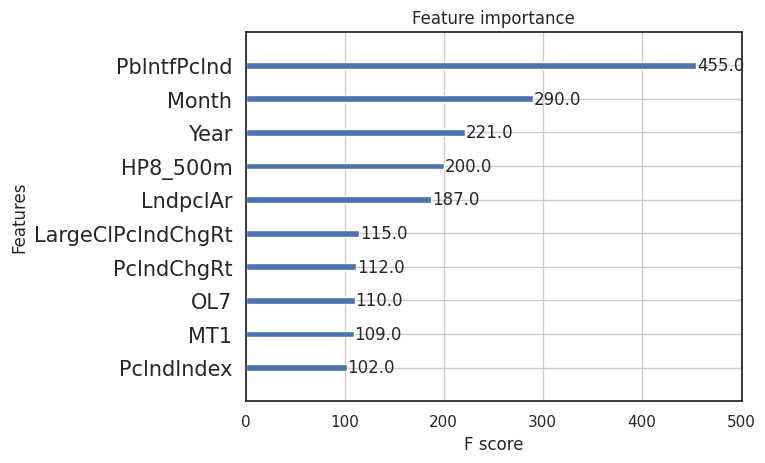

In [20]:
plot_importance(model, max_num_features=10)

plt.yticks(fontsize=15)
plt.show()

### **Evaluation and Validation**

In [21]:
relation_square = model.score(train_x, train_y)
print("R-Squared: ", relation_square)

predict_y = model.predict(test_x)
#predict_y = np.exp(predict_y_log) - 1
#test_y = np.exp(test_y) - 1
result = pd.DataFrame({'pred' : predict_y, 'real' : test_y})
print("RMSE score: {:,.0f}".format(mean_squared_error(test_y, predict_y) ** 0.5))

result['ratio(%)'] = (abs(result['pred'] - result['real']) / result['real']) * 100

/usr/anaconda3/envs/lvpm/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [17:33:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


R-Squared:  0.9999689096923781
RMSE score: 1,903,830


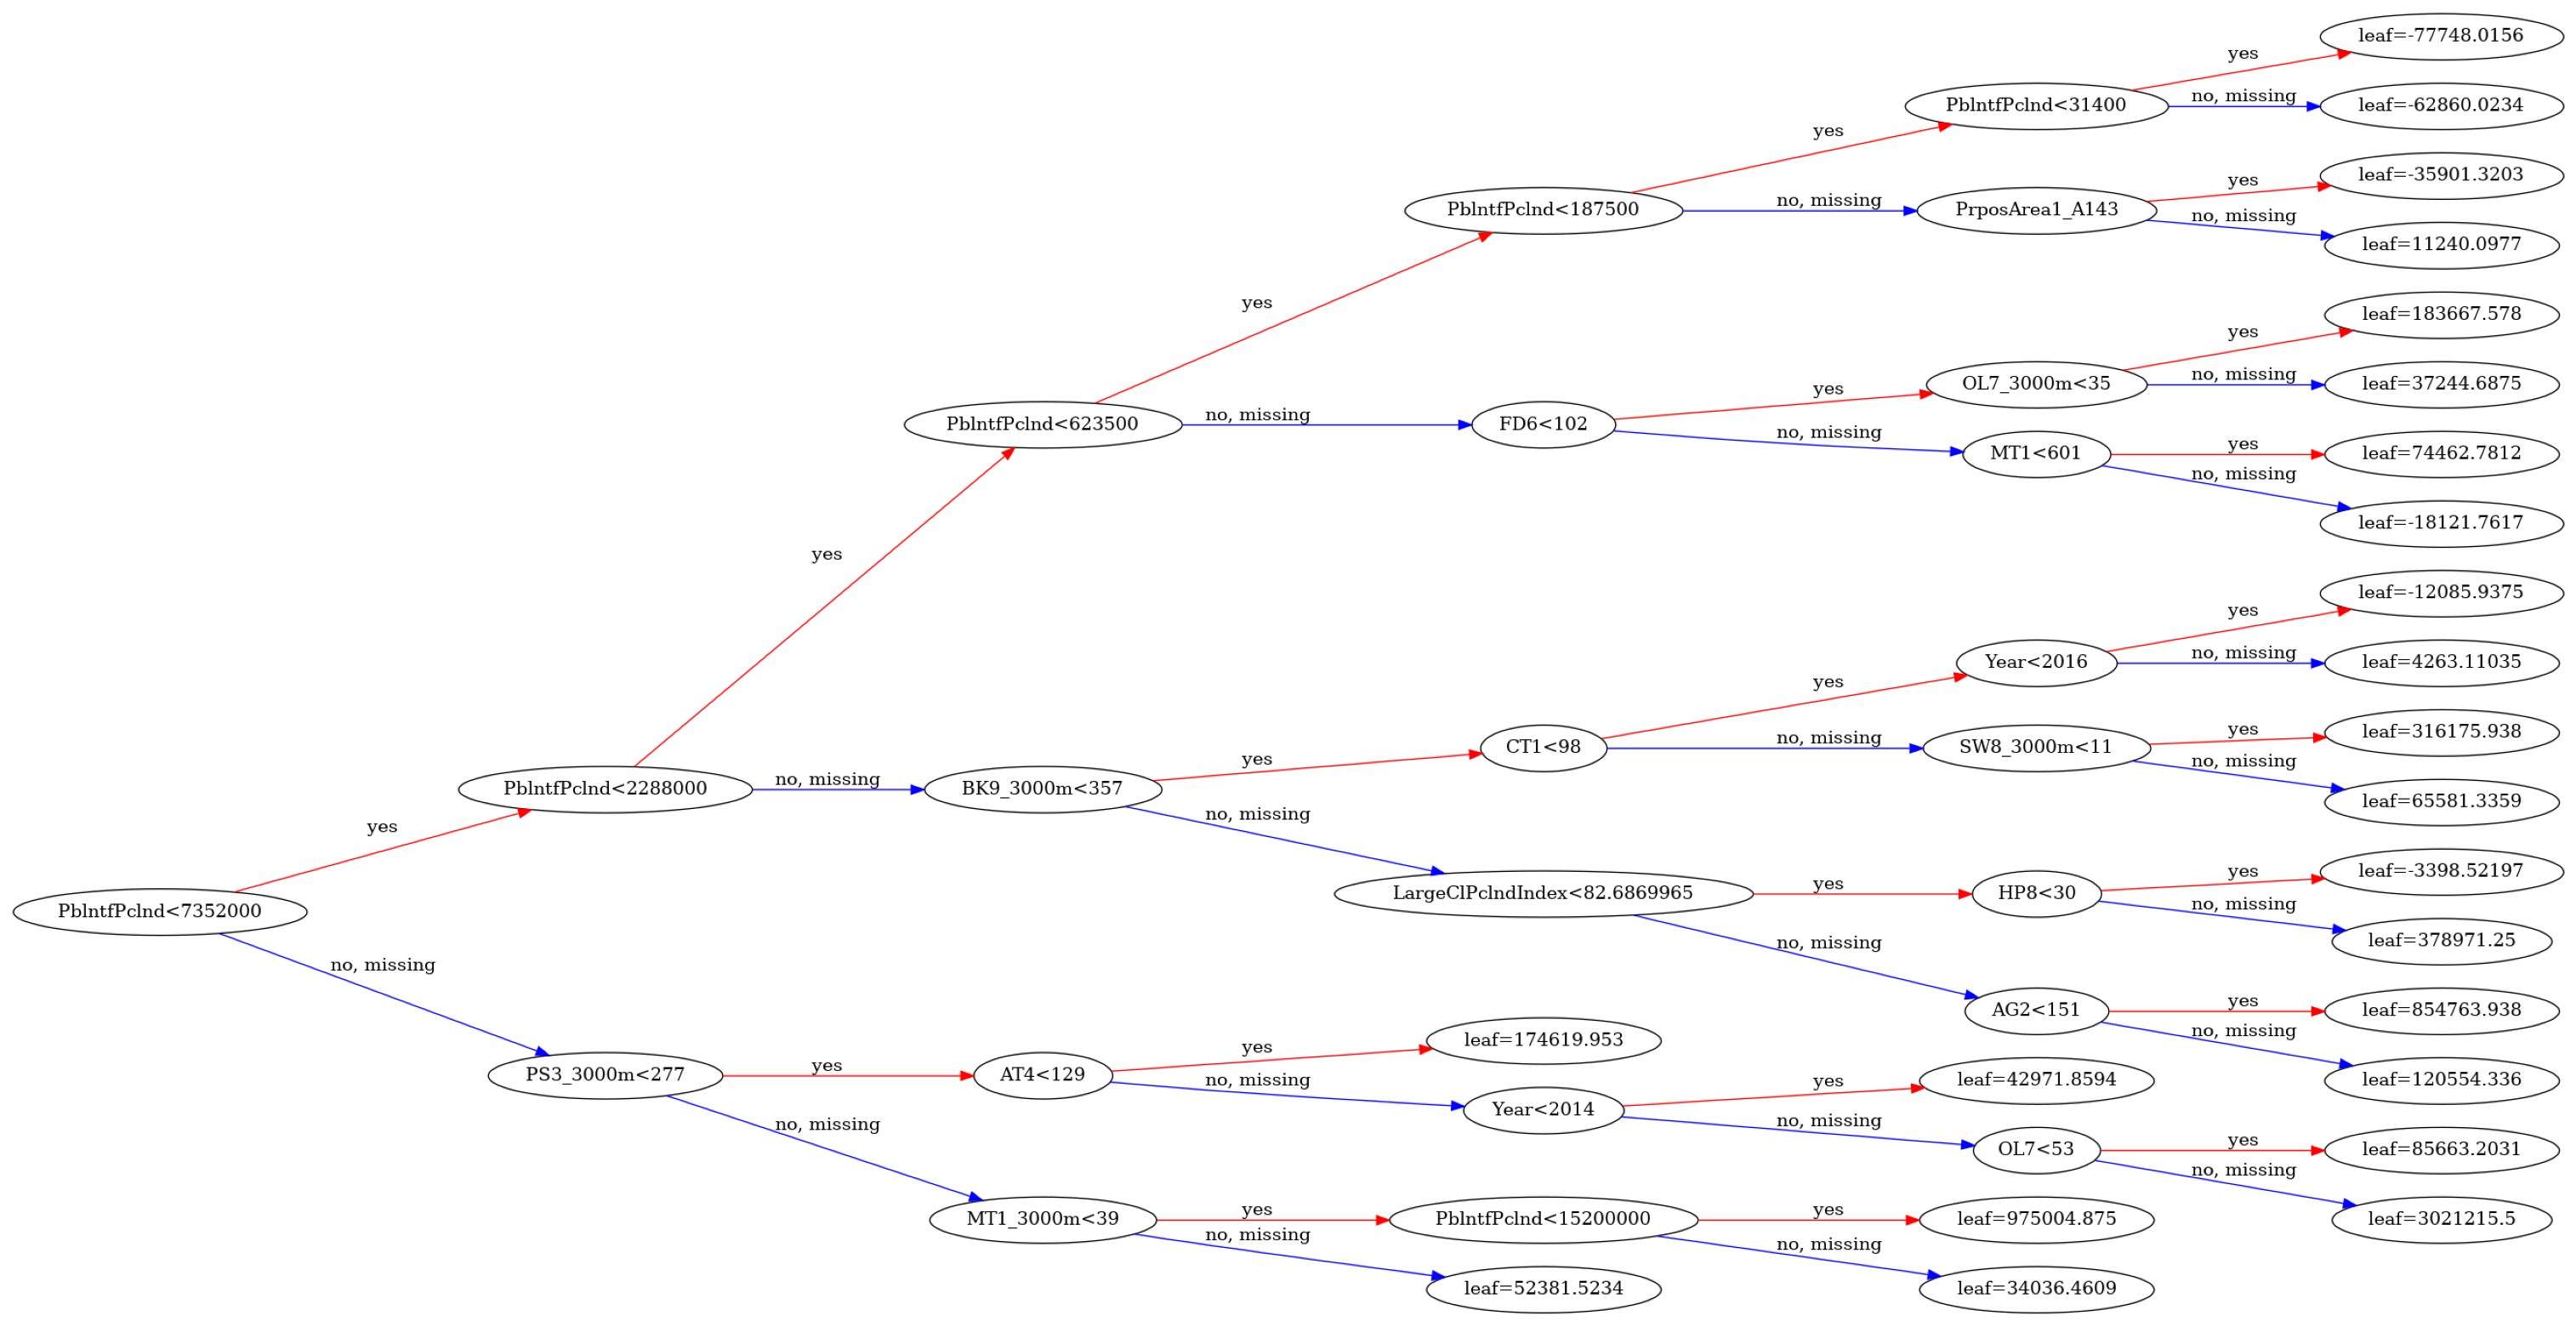

In [22]:
# Model visualization
fig, ax = plt.subplots(figsize=(100, 20))
xgb.plot_tree(model, num_trees=4, rankdir='LR', ax=ax)
plt.show()

In [23]:
print(result.sort_values("ratio(%)"))
for r in [3, 5, 10, 20]:
    print("ratio < {:2d}%: {:5d} / {:5d} ({:4.2f}%)".format(
        r, len(result[result["ratio(%)"] < r]), len(result), len(result[result["ratio(%)"] < r])/len(result)*100
    ))

           pred   real  ratio(%)
1383   21026.50  21063      0.17
1053   69442.69  69576      0.19
572    24256.19  24200      0.23
407    27743.31  27672      0.26
582     3942.75   3931      0.30
...         ...    ...       ...
788   403640.94  23606   1609.91
1146   10793.19    630   1613.20
740   -78655.44   4726   1764.31
321     7049.44    300   2249.81
585    33147.50   1301   2447.85

[1410 rows x 3 columns]
ratio <  3%:    55 /  1410 (3.90%)
ratio <  5%:    87 /  1410 (6.17%)
ratio < 10%:   185 /  1410 (13.12%)
ratio < 20%:   336 /  1410 (23.83%)


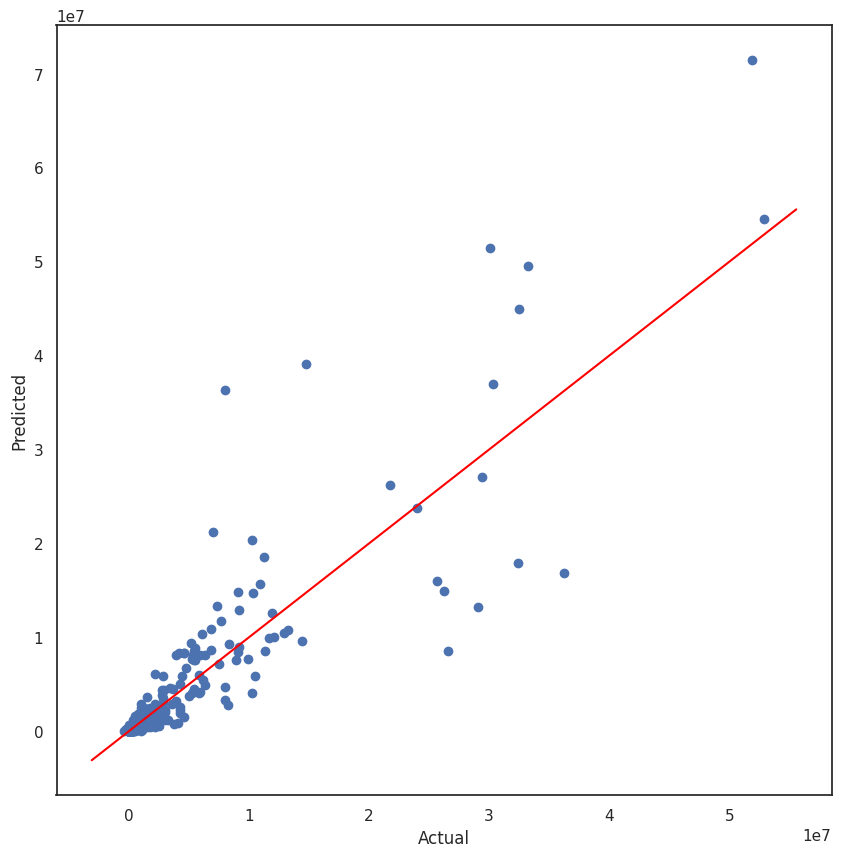

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data=result, x="pred", y="real")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='red')
plt.show()

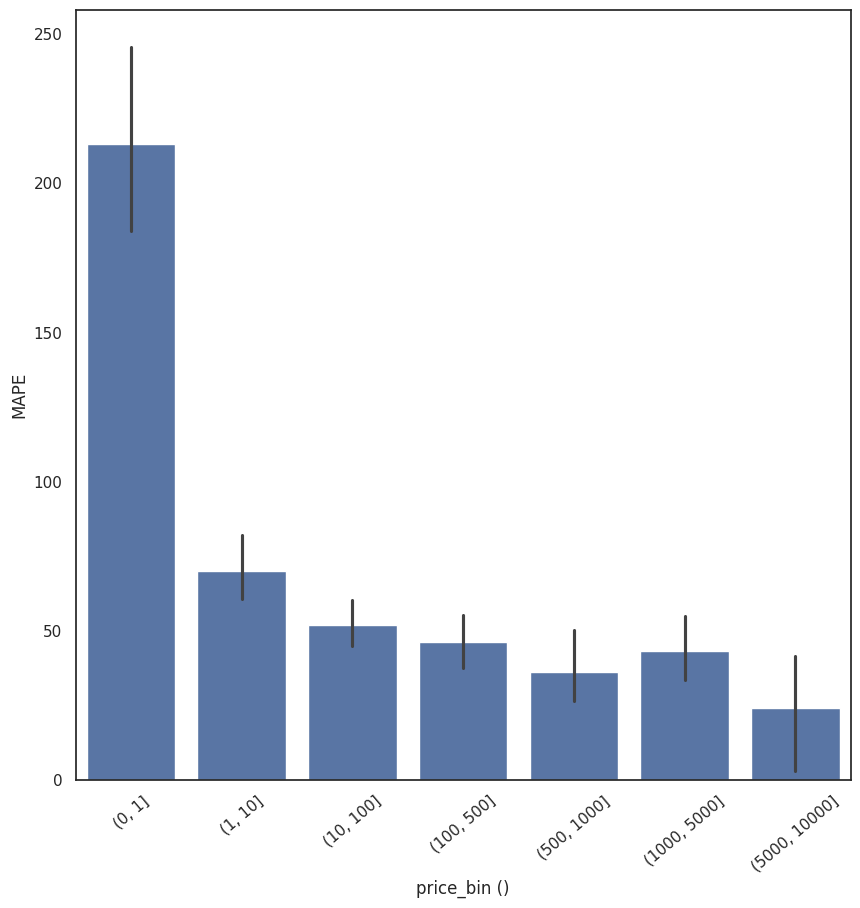

In [25]:
price_bin = pd.cut(test_y/10000,bins=[0,1,10,100,500,1000,5000,10000])
mape = result["ratio(%)"]

fig,ax = plt.subplots(1,figsize=(10,10))
sns.barplot(x=price_bin, y=mape)
ax.set_ylabel('MAPE')
ax.set_xlabel('price_bin ()')
plt.xticks(rotation=40)
plt.show()

In [26]:
price_bin

[(10, 100], (100, 500], (100, 500], (10, 100], (0, 1], ..., (1, 10], (100, 500], (0, 1], (10, 100], (1000, 5000]]
Length: 1410
Categories (7, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 500] < (500, 1000] < (1000, 5000] < (5000, 10000]]

<Axes: xlabel='ratio(%)', ylabel='Density'>

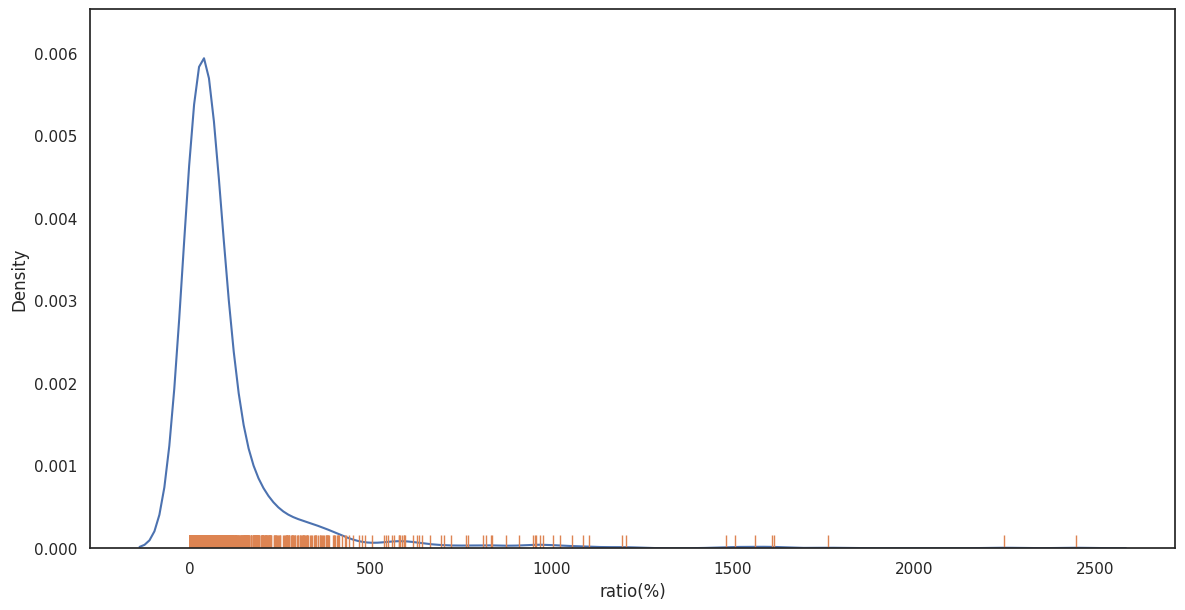

In [27]:
fig = plt.subplots(figsize=(14, 7))
sns.kdeplot(result["ratio(%)"])
sns.rugplot(result["ratio(%)"])

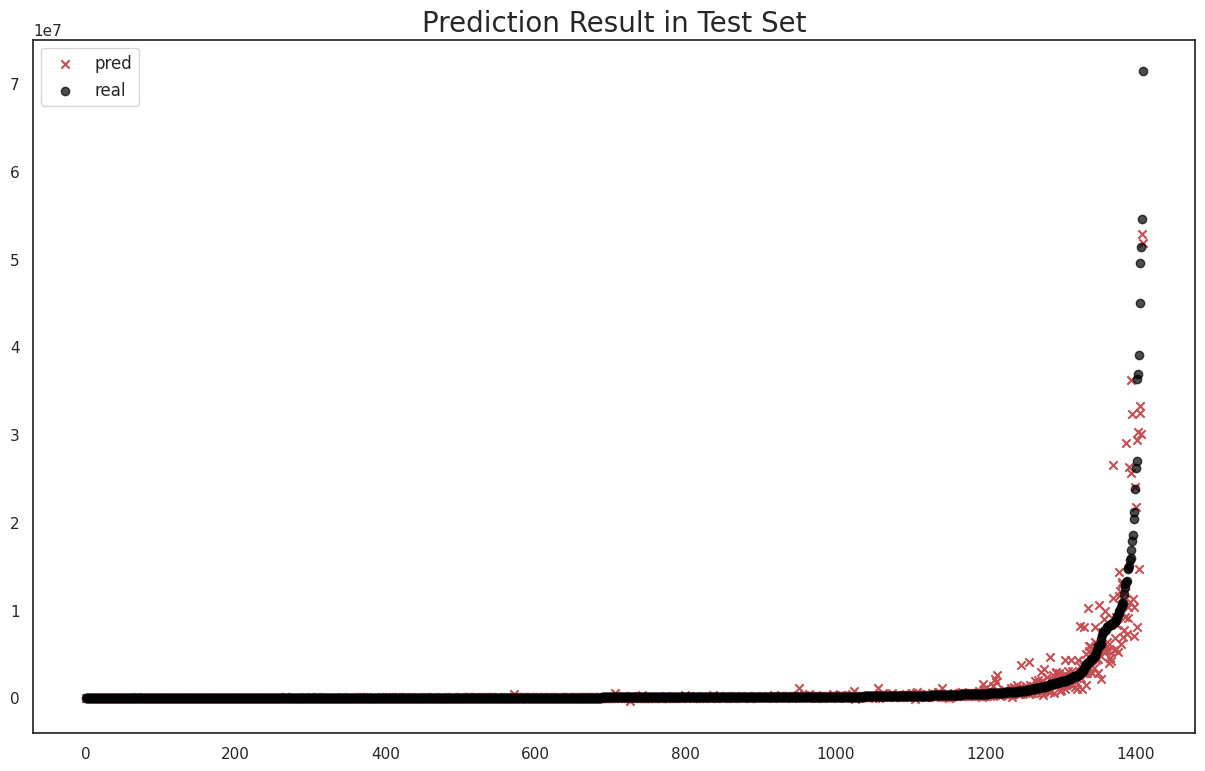

In [28]:
result = result.sort_values(by='real').reset_index(drop=True)

plt.figure(figsize=(15, 9))
plt.scatter(result.index, result['pred'], marker='x', color='r')
plt.scatter(result.index, result['real'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['pred', 'real'], fontsize=12)
plt.show()

## **Model Save**

In [29]:
model.save_model("../Models/xgboost_model.json")

## **Model Load**

In [30]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("../Models/xgboost_model.json")

In [31]:
loaded_model

XGBRegressor(base_score='9.524525E5', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'int', 'int', 'int', 'int', 'int...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## **Model Validate**

In [32]:
import src.data.make_input_data as mid
    
target_pnu = "1147010100109370018"
target_date = "202312"
target_land = mid.make(target_pnu, target_date)

In [33]:
target_feature = {}
for feature in loaded_model.feature_names_in_:
    if not feature in target_land.keys():
        if feature.split("_")[0] == "Sido":
            target_feature[feature] = feature.split("_")[1] == target_land["PNU"][0:2]
        elif feature.split("_")[0] == "LandUsePlans":
            target_feature[feature] = feature.split("_")[1] in target_land["LandUsePlans"].split("/")
        else:
            target_feature[feature] = feature.split("_")[1] in target_land[feature.split("_")[0]]
    else:
        target_feature[feature] = target_land[feature]

In [34]:
target_x = pd.DataFrame.from_dict(data=[target_feature], orient="columns", dtype=float)
target_predict = loaded_model.predict(target_x)

In [35]:
import src.data.convert_code as cc

# pd.set_option('display.max_rows',None) # 전체 행 출력하기

land_info_str = "평가된 토지 예측가: {:,d}원/㎡당\n\n".format(abs(int(target_predict)))
land_use_plan_str = ""
place_info_str = "== 주변 상권 정보 ==\n"
for k, v in target_x.iloc[0].items():
    if v == 0.0:
        continue
    if k[0:3] in cc.PLACE_CODE.keys():
        place_kr = cc.PLACE_CODE[k[0:3]]
        if len(k.split("_")) == 2:
            place_info_str += "{} 이내에 있는 {}의 수: {:,d}개\n".format(k.split("_")[1], place_kr, int(v))
        else:
            if v == 20000:
                continue
            place_info_str += "{} 최소 거리: {:,d}m\n".format(place_kr, int(v))
    elif len(k.split("_")) == 2:
        if k.split("_")[0] == "LdCode":
            jibun = cc.code2addr(k.split("_")[1])
            land_info_str += f"지번주소: {jibun}\n"
        if k.split("_")[0] == "RegstrSe":
            re = cc.code2regstr(k.split("_")[1][2:3])
            land_info_str += f"필지: {re}\n"
        if k.split("_")[0] == "Lndcgr":
            lc = cc.code2lndcgr(k.split("_")[1][2:4])
            land_info_str += f"지목: {lc}\n"
        if k.split("_")[0] == "PrposArea1":
            a1 = cc.code2zoning(k.split("_")[1][2:4])
            land_info_str += f"용도지역: {a1}\n"
        if k.split("_")[0] == "LadUseSittn":
            us = cc.code2landcategory(k.split("_")[1][2:5])
            land_info_str += f"이용상황: {us}\n"
        if k.split("_")[0] == "TpgrphHg":
            th = cc.code2tpgrphhg(k.split("_")[1][2:4])
            land_info_str += f"토지지세: {th}\n"
        if k.split("_")[0] == "TpgrphFrm":
            tf = cc.code2tpgrphfrm(k.split("_")[1][2:4])
            land_info_str += f"토지형상: {tf}\n"
        if k.split("_")[0] == "TpgrphHg":
            rs = cc.code2roadside(k.split("_")[1][2:4])
            land_info_str += f"도로접면: {rs}\n"
        if k.split("_")[0] == "LandUsePlans":
            print(k)
            land_use_plan_str += cc.code2useplan(k.split("_")[1]) + ", "
    # print(f"- {k}: {v}")

land_info_str += "토지면적: {:,}㎡\n".format(target_x.iloc[0]["LndpclAr"])
land_info_str += "기준년도: {}년\n".format(target_x.iloc[0]["Year"])
land_info_str += "기준월: {}월\n".format(target_x.iloc[0]["Month"])
land_info_str += "개별공시지가: {:,d}원/㎡당\n".format(int(target_x.iloc[0]["PblntfPclnd"]))
land_info_str += "지가지수: {}\n".format(target_x.iloc[0]["PclndIndex"])
land_info_str += "지가변동률: {}%\n".format(target_x.iloc[0]["PclndChgRt"])
land_info_str += "누계지가변동률: {}%\n".format(target_x.iloc[0]["AcmtlPclndChgRt"])
land_info_str += "권역별지가지수: {}\n".format(target_x.iloc[0]["LargeClPclndIndex"])
land_info_str += "권역별지가변동률: {}%\n".format(target_x.iloc[0]["LargeClPclndChgRt"])
land_info_str += "권역별누계지가변동률: {}%\n".format(target_x.iloc[0]["LargeClAcmtlPclndChgRt"])
land_info_str += "생산자물가지수: {}\n".format(target_x.iloc[0]["PPI"])
land_info_str += "소비자물가지수: {}\n".format(target_x.iloc[0]["CPI"])

land_info_str += f"이용계획: {land_use_plan_str[:-2]}"

info_str = land_info_str + "\n\n" + place_info_str

print(info_str)

LandUsePlans_UBA100(1)
LandUsePlans_UIG530(1)
LandUsePlans_UMZ100(1)
LandUsePlans_UNE200(1)
LandUsePlans_UOA100(1)
LandUsePlans_UQA01X(1)
LandUsePlans_UQA122(1)
LandUsePlans_UQS100(3)
평가된 토지 예측가: 6,967,388원/㎡당

필지: 일반
지목: 대
용도지역: 제2종일반주거지역
이용상황: 다세대
토지지세: 평지
도로접면: 광대소각
토지형상: 사다리형
토지면적: 291.3㎡
기준년도: 2023.0년
기준월: 12.0월
개별공시지가: 3,757,000원/㎡당
지가지수: 101.125
지가변동률: 0.183%
누계지가변동률: 0.652%
권역별지가지수: 101.116
권역별지가변동률: 0.193%
권역별누계지가변동률: 1.106%
생산자물가지수: 121.19
소비자물가지수: 112.71
이용계획: 과밀억제권역<포함>, 원추표면구역<포함>, 가축사육제한구역<포함>, 대공방어협조구역<포함>, 교육환경보호구역<포함>, 도시지역<포함>, 제2종일반주거지역<포함>, 도로<접함>

== 주변 상권 정보 ==
대형마트 최소 거리: 337m
500m 이내에 있는 대형마트의 수: 1개
1000m 이내에 있는 대형마트의 수: 4개
3000m 이내에 있는 대형마트의 수: 29개
편의점 최소 거리: 45m
500m 이내에 있는 편의점의 수: 20개
1000m 이내에 있는 편의점의 수: 103개
3000m 이내에 있는 편의점의 수: 554개
어린이집 및 유치원 최소 거리: 35m
500m 이내에 있는 어린이집 및 유치원의 수: 15개
1000m 이내에 있는 어린이집 및 유치원의 수: 76개
3000m 이내에 있는 어린이집 및 유치원의 수: 536개
학교 최소 거리: 112m
500m 이내에 있는 학교의 수: 3개
1000m 이내에 있는 학교의 수: 10개
3000m 이내에 있는 학교의 수: 92개
학원 최소 거리: 45m
500m 이내에 있

In [36]:
from src.llm import land_appraisal

sys_msg_str = """
    너는 이제부터 토지의 가치를 평가하는 감정평가사야. 주어진 정보를 바탕으로 평가된 토지 가격이 어떻게 산출되었는지 논리적으로 설명해야해.
    모든 설명을 마치고 마지막에는 제곱미터당 가격과 토지면적과 곱한 가격을 모두 말해줘야해.
    
    
"""

sys_msg_str = """
    너는 이제부터 토지의 가치를 평가하는 감정평가사야. 주어진 정보를 바탕으로 평가된 토지 가격이 어떻게 산출되었는지 논리적으로 설명해야해.
    모든 설명을 마치고 마지막에는 제곱미터당 가격과 토지면적과 곱한 가격을 모두 말해줘야해.
    
    아래 결정트리에 의거해서 논리적으로 왜 가격을 그렇게 예측했는지 설명해줘.
"""

tree_text = "\n== 결정트리 ==\n"
tree_dump = loaded_model.get_booster().get_dump()
for i, tree in enumerate(tree_dump):
    tree_text += f"Tree {i}:\n{tree}"
    break

sys_msg_str += tree_text

result = land_appraisal.create(land_info=info_str, sys_msg=sys_msg_str)

In [37]:
print(tree_text)


== 결정트리 ==
Tree 0:
0:[PblntfPclnd<4728000] yes=1,no=2,missing=2
	1:[PblntfPclnd<1592000] yes=3,no=4,missing=4
		3:[PblntfPclnd<419000] yes=7,no=8,missing=8
			7:[PblntfPclnd<131000] yes=15,no=16,missing=16
				15:[MT1_3000m<31] yes=25,no=26,missing=26
					25:leaf=-197736.266
					26:leaf=-3778.89014
				16:[PblntfPclnd<326000] yes=27,no=28,missing=28
					27:leaf=-120212.977
					28:leaf=-47671.3516
			8:[PblntfPclnd<623500] yes=17,no=18,missing=18
				17:[CE7<59] yes=29,no=30,missing=30
					29:leaf=69068.4141
					30:leaf=-22785.1016
				18:[AG2_500m<20] yes=31,no=32,missing=32
					31:leaf=80791.4375
					32:leaf=260245.531
		4:[PblntfPclnd<2288000] yes=9,no=10,missing=10
			9:[PPI<98.3199997] yes=19,no=20,missing=20
				19:leaf=60958.2812
				20:[LandUsePlans_UQV700(3)<1] yes=33,no=34,missing=34
					33:leaf=427507.938
					34:leaf=2423.22998
			10:[PO3_1000m<4] yes=21,no=22,missing=22
21:[Lndcgr_Lc11] yes=35,no=36
					35:leaf=421876.719
					36:leaf=18433.1895
				22:[LndpclAr<

In [38]:
print(result)

토지 가격은 여러 요소에 의해 측정되지만 이 경우에는 주어진 결정트리를 통해 예측된 가격입니다. 결정트리는 일련의 질문을 통해 해결하려는 문제에 대한 결정을 내리는 모델입니다. 이 경우에는, 주어진 정보에 따라 토지 가치를 평가하는데 사용됩니다. 

토지 항목은 개별공시지가에 따라 분류되었고, 해당 값은 3,757,000원으로 주어졌습니다. 이는 처음의 분류기준인 4,728,000원보다 작고, 다음 분류 기준인 1,592,000원보다 크므로, 두 번째 노드로 넘어갑니다. 여기에서는 토지 항목이 2,288,000원보다 작음에 따라, 9번 노드로 이동합니다. 9번 노드에서는 생산자물가지수(PPI)가 사정된 분할 값인 98.32보다 크기 때문에, 20번 노드로 이동합니다. 

20번 노드에서는 이용계획 'LandUsePlans_UQV700(3)'의 값이 1보다 작아야 하지만, 우리 데이터에서 이 필드는 명시되어 있지 않으므로 이 결정은 불확실합니다. 그러므로 34번 노드로 이동하여 2,423.22998의 leaf 값을 얻게 됩니다. 

따라서, 감정평가사는 제곱미터당 가격이 약 2,423.23원이라고 평가했습니다. 이 토지의 면적이 291.3㎡이므로, 최종적으로 평가된 토지 가격은 약 706,131,362.8원(2,423.23원/㎡ x 291.3㎡)입니다. 이렇게 결과적으로 해당 토지의 가치를 평가하는 방식이 결정트리를 이용한 가치 예측 방식입니다.
